In [1]:
# Directories for train audio & image
from pathlib import Path

TRAIN_AUDIO = Path("./data")
TRAIN_IMAGE = Path("./image")
TRAIN_IMAGE.mkdir(exist_ok=True, parents=True)

In [2]:
!pip install librosa
!pip install numpy
!pip install soundfile

In [3]:
# Class for Mel-Spectrogram converter
# !pip install librosa
import librosa
import librosa.display

# !pip install numpy
import numpy as np
import matplotlib.pyplot as plt

# !pip install soundfile
import soundfile
from soundfile import SoundFile

In [4]:
class MelConverter:
    def __init__(self, sr, n_mels, n_fft, hop_length):
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

    # Print the shape of given spectrogram
    def print_shape(self, S):
        print("Shape : {}".format(np.shape(S)))

    # Print the length of audio input (in sec.)
    def print_length(self, y):
        print("Length : {}".format(len(y) / self.sr))

    # Print the image of spectrogram
    def print_image(self, S):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            S, x_axis='time', y_axis='mel', sr=self.sr,
            hop_length=self.hop_length 
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.tight_layout()
        plt.show()

    # Convert numpy array to spectrogram
    def convert(self, y):
        S = librosa.feature.melspectrogram(
            y=y, sr=self.sr, hop_length=self.hop_length,
            n_mels=self.n_mels, n_fft=self.n_fft,
            fmin=0, fmax=(self.sr // 2)
        )
        return S, y
    
    # Apply filter to converted spectrogram
    def filter(self, S):
        filter_S = librosa.power_to_db(S).astype(np.float32)
        return filter_S

    # Standardize spectrogram with HEX color
    def standardize(self, S):
        S = (S - S.mean()) / (S.std() + 1e-6)
        min = S.min()
        max = S.max()
        range = max - min

        if range > 1e-6:
            S = 255 * (S - min) / range
        else:
            S = np.zeros_like(S, dtype=np.uint8)
        return S

In [5]:
class AudioToImage:
    def __init__(self, sr=32000, n_mels=128, n_fft=3200, 
            hop_length=800, time_length=7):
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.time_length = time_length
        self.audio_length = self.time_length * self.sr
        self.mel_converter = MelConverter(
            sr=self.sr, n_mels=self.n_mels, 
            n_fft=self.n_fft, hop_length=self.hop_length
        )

    def crop(self, audio):
        # If given audio is shorter than favorable length
        if len(audio) < self.audio_length:
            audio = np.concatenate(
                [audio, np.zeros(self.audio_length - len(audio))]
            )
        # If give audio is longer than favorable length
        else:
            audio = audio[0:self.audio_length]
        return audio

    def audio_to_image(self, audio):
        S, y = self.mel_converter.convert(audio)
        S = self.mel_converter.filter(S)
        S = self.mel_converter.standardize(S)
        return S

    def get_metadata(filepath):
        f = SoundFile(filepath)
        return f.samplerate, f.frames
    
    def convert(self, filename, show_image=False):
        audio, sr = soundfile.read(str(TRAIN_AUDIO) + '/' + filename)
        if sr != self.sr:
            audio = librosa.resample(audio, sr, self.sr, res_type="kaiser_fast")

        chopped_audio = []
        for i in range(0, max(1, len(audio) - (self.audio_length - 1)), self.audio_length):
            chopped_audio.append(
                audio[i : i + self.audio_length]
            )
        chopped_audio[-1] = self.crop(chopped_audio[-1])

        converted_image = []
        for j in range(len(chopped_audio)):
            converted_image.append(
                self.audio_to_image(chopped_audio[j])
            )
        converted_image = np.stack(converted_image)
        np.save(str(TRAIN_IMAGE) + '/' + filename + '.npy', converted_image)
        
        if show_image:
            self.mel_converter.print_shape(converted_image)
            self.mel_converter.print_image(converted_image[0])

Shape : (9, 128, 281)


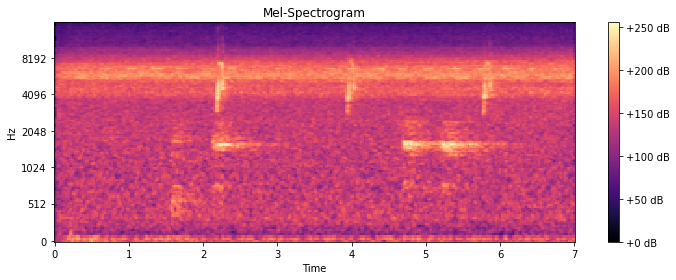

In [6]:
converter = AudioToImage()
result = converter.convert("XC109605.ogg", True)